In [1]:
import pandas as pd

import os

import json
from tqdm import tqdm
import numpy as np
import itertools

import tensorflow as tf
import tensorflow.keras.layers as layers

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    print("Name:", gpu.name, "  Type:", gpu.device_type)

Name: /physical_device:GPU:0   Type: GPU
Name: /physical_device:GPU:1   Type: GPU


In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')

if gpus:
  try:
    tf.config.experimental.set_visible_devices(gpus, 'GPU')
  except RuntimeError as e:
    print(e)

In [4]:
class CONFIG:
    ROOT_DIR = '/kaggle/input/asl-signs'
    TRAIN_DATA = '/kaggle/input/asl-signs/train.csv'
    EXTENDED_TRAIN_DATA = '/kaggle/input/gislr-extended-train-dataframe/extended_train.csv'
    TRAIN_DIR = '/kaggle/input/asl-signs/train_landmark_files'
    PREDICTION_INDEX_MAP = '/kaggle/input/asl-signs/sign_to_prediction_index_map.json'
    
    TOTAL_DATA = 94477
    LANDMARKS_PER_FRAME = 543
    AVERAGE_FRAME = 37
    SEED = 11
    
    CONTOURS = [0, 9, 11, 13, 14, 17, 117, 118, 119, 199, 346, 347, 348]

    LANDMARKS_IDX = {"face" : CONTOURS,
                     "left_hand" : list(range(468, 489)),
                     "upper_body" : list(range(489, 511)),
                     "right_hand" : list(range(522, 543))}

In [5]:
def read_json_file(json_path):
    with open(json_path, "rb") as f:
        json_data = json.load(f)
    
    return json_data

def load_landmarks(pq_path):
    data_columns = ['x', 'y', 'z']
    
    data = pd.read_parquet(pq_path, columns=data_columns)
    n_frames = int(len(data) / CONFIG.LANDMARKS_PER_FRAME)
    data = data.values.reshape(n_frames, CONFIG.LANDMARKS_PER_FRAME, len(data_columns))
    
    return data.astype(np.float32)

In [6]:
train_df = pd.read_csv(CONFIG.EXTENDED_TRAIN_DATA)

label_map = read_json_file(CONFIG.PREDICTION_INDEX_MAP)

train_df['label'] = train_df['sign'].map(label_map)

In [7]:
train_df.head()

,path,participant_id,sequence_id,sign,start_frame,end_frame,total_frames,face_count,face_nan_count,pose_count,...,left_hand_nan_count,right_hand_count,right_hand_nan_count,x_min,x_max,y_min,y_max,z_min,z_max,label
0,/kaggle/input/asl-signs/train_landmark_files/2...,26734,1000035562,blow,20,42,23,10764,0,759,...,483,483,252,-0.031811,1.294350,-2.147826,-0.224151,-2.782624,1.910815,25
1,/kaggle/input/asl-signs/train_landmark_files/2...,28656,1000106739,wait,29,39,11,5148,0,363,...,231,231,189,-0.017062,1.015931,-2.222732,-0.329273,-2.543970,1.627621,232
2,/kaggle/input/asl-signs/train_landmark_files/1...,16069,100015657,cloud,103,207,105,49140,0,3465,...,1617,2205,2205,-0.042923,1.197836,-2.591290,-0.248094,-2.838325,1.587503,48
3,/kaggle/input/asl-signs/train_landmark_files/2...,25571,1000210073,bird,17,28,12,5616,0,396,...,252,252,0,-0.129268,1.156573,-2.294936,-0.310272,-3.018237,2.196296,23
4,/kaggle/input/asl-signs/train_landmark_files/6...,62590,1000240708,owie,22,39,18,8424,0,594,...,378,378,0,0.072425,1.165405,-2.264609,-0.405282,-2.970331,1.360011,164


## Feature Pre-processing

In [8]:
class FeaturePreprocess(layers.Layer):
    def __init__(self):
        super(FeaturePreprocess, self).__init__()
        
        self.AVERAGE_FRAME = 37
        
        self.CONTOURS = [0, 9, 11, 13, 14, 17, 117, 118, 119, 199, 346, 347, 348]

        self.LANDMARKS_IDX = {"face" : self.CONTOURS,
                              "left_hand" : list(range(468, 489)),
                              "upper_body" : list(range(489, 511)),
                              "right_hand" : list(range(522, 543))}

    def call(self, x):
        n_frames = x.shape[0]

        # Normalization to a common mean
        x = x - tf.math.reduce_mean(tf.boolean_mask(x, ~tf.math.is_nan(x), axis=0), axis=0, keepdims=True)
        x = x / tf.math.reduce_std(tf.boolean_mask(x, ~tf.math.is_nan(x), axis=0), axis=0, keepdims=True)

        # Landmarks reduction
        contours = tf.gather(x, self.LANDMARKS_IDX['face'], axis=1)
        left_hand = tf.gather(x, self.LANDMARKS_IDX['left_hand'], axis=1)
        pose = tf.gather(x, self.LANDMARKS_IDX['upper_body'], axis=1)
        right_hand = tf.gather(x, self.LANDMARKS_IDX['right_hand'], axis=1)
       
        x = tf.concat([contours, left_hand, pose, right_hand], axis=1)  # (n_frames, 192, 3)

        # Replace nan with 0
        x = tf.where(tf.math.is_nan(x), tf.zeros_like(x), x)
        x = x[tf.newaxis, ...]

        x = tf.image.resize(x, size=(self.AVERAGE_FRAME, x.shape[2]), method="bilinear")

        return tf.squeeze(x, axis=0)

In [9]:
feature_preprocess = FeaturePreprocess()

def convert_row(row):
    x = tf.convert_to_tensor(load_landmarks(row.path))
    x = feature_preprocess(x).numpy()

    return x, row.label

def convert_and_save_data(df, data_path, label_path, save_data=False):
    total = df.shape[0]
    npdata = np.zeros((total, 37, 77, 3))
    nplabels = np.zeros(total)
    
    for i, row in tqdm(df.iterrows(), total=total):
        x, y = convert_row(row)
        npdata[i,:,:,:] = x
        nplabels[i] = y
    
    if save_data:
        np.save(data_path, npdata)
        np.save(label_path, nplabels)
    
    return npdata, nplabels


In [10]:
features_path = "/kaggle/input/asl-pretrained/processed_features.npy"
labels_path = "/kaggle/input/asl-pretrained/processed_labels.npy"

In [11]:
# features, labels = convert_and_save_data(train_df, features_path, labels_path)

In [12]:
features = np.load(features_path)
labels = np.load(labels_path)

In [13]:
features = features[:80000]
labels = labels[:80000]

In [14]:
test_size=0.2

X_train, X_val, y_train, y_val = train_test_split(features, labels, test_size=test_size, random_state=CONFIG.SEED)

del features, labels # delete, useful with full data otherwise it fail (memory issues)

In [15]:
buffer_size = int(CONFIG.TOTAL_DATA / 1000)

train_data = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_data = train_data.shuffle(buffer_size).batch(128, drop_remainder=True).prefetch(tf.data.AUTOTUNE)

val_data = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_data = val_data.batch(128, drop_remainder=True).prefetch(tf.data.AUTOTUNE)

del X_train, X_val, y_train, y_val

## Model

In [16]:
class DenseBlock(layers.Layer):
    def __init__(self, units, drop):
        super().__init__()
        self.dense = layers.Dense(units)
        self.norm = layers.LayerNormalization()
        self.relu = layers.Activation("relu")
        self.drop = layers.Dropout(drop)
        
    def call(self, x):
        x = self.dense(x)
        x = self.norm(x)
        x = self.relu(x)
        x = self.drop(x)
        
        return x

In [17]:
class ClassifierConvLSTM1D(layers.Layer):
    def __init__(self, lstm_units, drop):
        super().__init__()
        self.pool2d = layers.AveragePooling2D(pool_size=(6, 1))
        self.conv_lstm1D = layers.ConvLSTM1D(filters=lstm_units, kernel_size=1)
        self.dropout = layers.Dropout(drop)
        self.flat = layers.Flatten()
        self.outputs = layers.Dense(250, activation="softmax", name="predictions")
    
    def call(self, x):
        x = self.pool2d(x)
        x = self.conv_lstm1D(x)
        x = self.dropout(x)
        x = self.flat(x)
        outputs = self.outputs(x)
        
        return outputs

In [18]:
def get_model(encoder_units=[128, 64], drop=0.1, lstm_units=250, shape=(37, 77, 3), learning_rate=0.001):
    inputs = layers.Input(shape=shape)
    x = inputs

    for units in encoder_units:
        x = DenseBlock(units, drop)(x)

    outputs = ClassifierConvLSTM1D(lstm_units, drop)(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    model.compile(
        loss="sparse_categorical_crossentropy",
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        metrics=["accuracy"],
    )

    return model

In [19]:
def get_callbacks():
    return [
        tf.keras.callbacks.EarlyStopping(
            monitor="val_accuracy", patience=10, restore_best_weights=True
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor="val_accuracy", factor=0.5, patience=3
        ),
        tf.keras.callbacks.ModelCheckpoint(
            "./ASL_model",
            save_best_only=True,
            restore_best_weights=True,
            monitor="val_accuracy",
            mode="max",
            verbose=False,
        ),
    ]


cb_list = get_callbacks()

model = get_model()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 37, 77, 3)]       0         
                                                                 
 dense_block (DenseBlock)    (None, 37, 77, 128)       768       
                                                                 
 dense_block_1 (DenseBlock)  (None, 37, 77, 64)        8384      
                                                                 
 classifier_conv_lstm1d (Cla  (None, 250)              5127750   
 ssifierConvLSTM1D)                                              
                                                                 
Total params: 5,136,902
Trainable params: 5,136,902
Non-trainable params: 0
_________________________________________________________________


In [20]:
history = model.fit(train_data, validation_data=val_data, epochs=50, callbacks=cb_list)

Epoch 1/50


2023-04-30 03:42:55.943673: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape ingradient_tape/model/dense_block_1/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


500/500 [==============================] - 118s 211ms/step - loss: 4.1556 - accuracy: 0.1504 - val_loss: 3.2363 - val_accuracy: 0.2839 - lr: 0.0010
Epoch 2/50
500/500 [==============================] - 102s 205ms/step - loss: 2.7842 - accuracy: 0.3654 - val_loss: 2.5971 - val_accuracy: 0.4099 - lr: 0.0010
Epoch 3/50
500/500 [==============================] - 103s 205ms/step - loss: 2.1862 - accuracy: 0.4852 - val_loss: 2.3812 - val_accuracy: 0.4640 - lr: 0.0010
Epoch 4/50
500/500 [==============================] - 102s 204ms/step - loss: 1.7988 - accuracy: 0.5663 - val_loss: 2.3033 - val_accuracy: 0.4912 - lr: 0.0010
Epoch 5/50
500/500 [==============================] - 102s 205ms/step - loss: 1.4832 - accuracy: 0.6334 - val_loss: 2.3439 - val_accuracy: 0.4942 - lr: 0.0010
Epoch 6/50
500/500 [==============================] - 98s 195ms/step - loss: 1.2275 - accuracy: 0.6883 - val_loss: 2.4824 - val_accuracy: 0.4841 - lr: 0.0010
Epoch 7/50
500/500 [==============================] - 97s 

In [21]:
model = tf.keras.models.load_model("./ASL_model")
score = model.evaluate(val_data)

125/125 [==============================] - 11s 88ms/step - loss: 2.8906 - accuracy: 0.5558


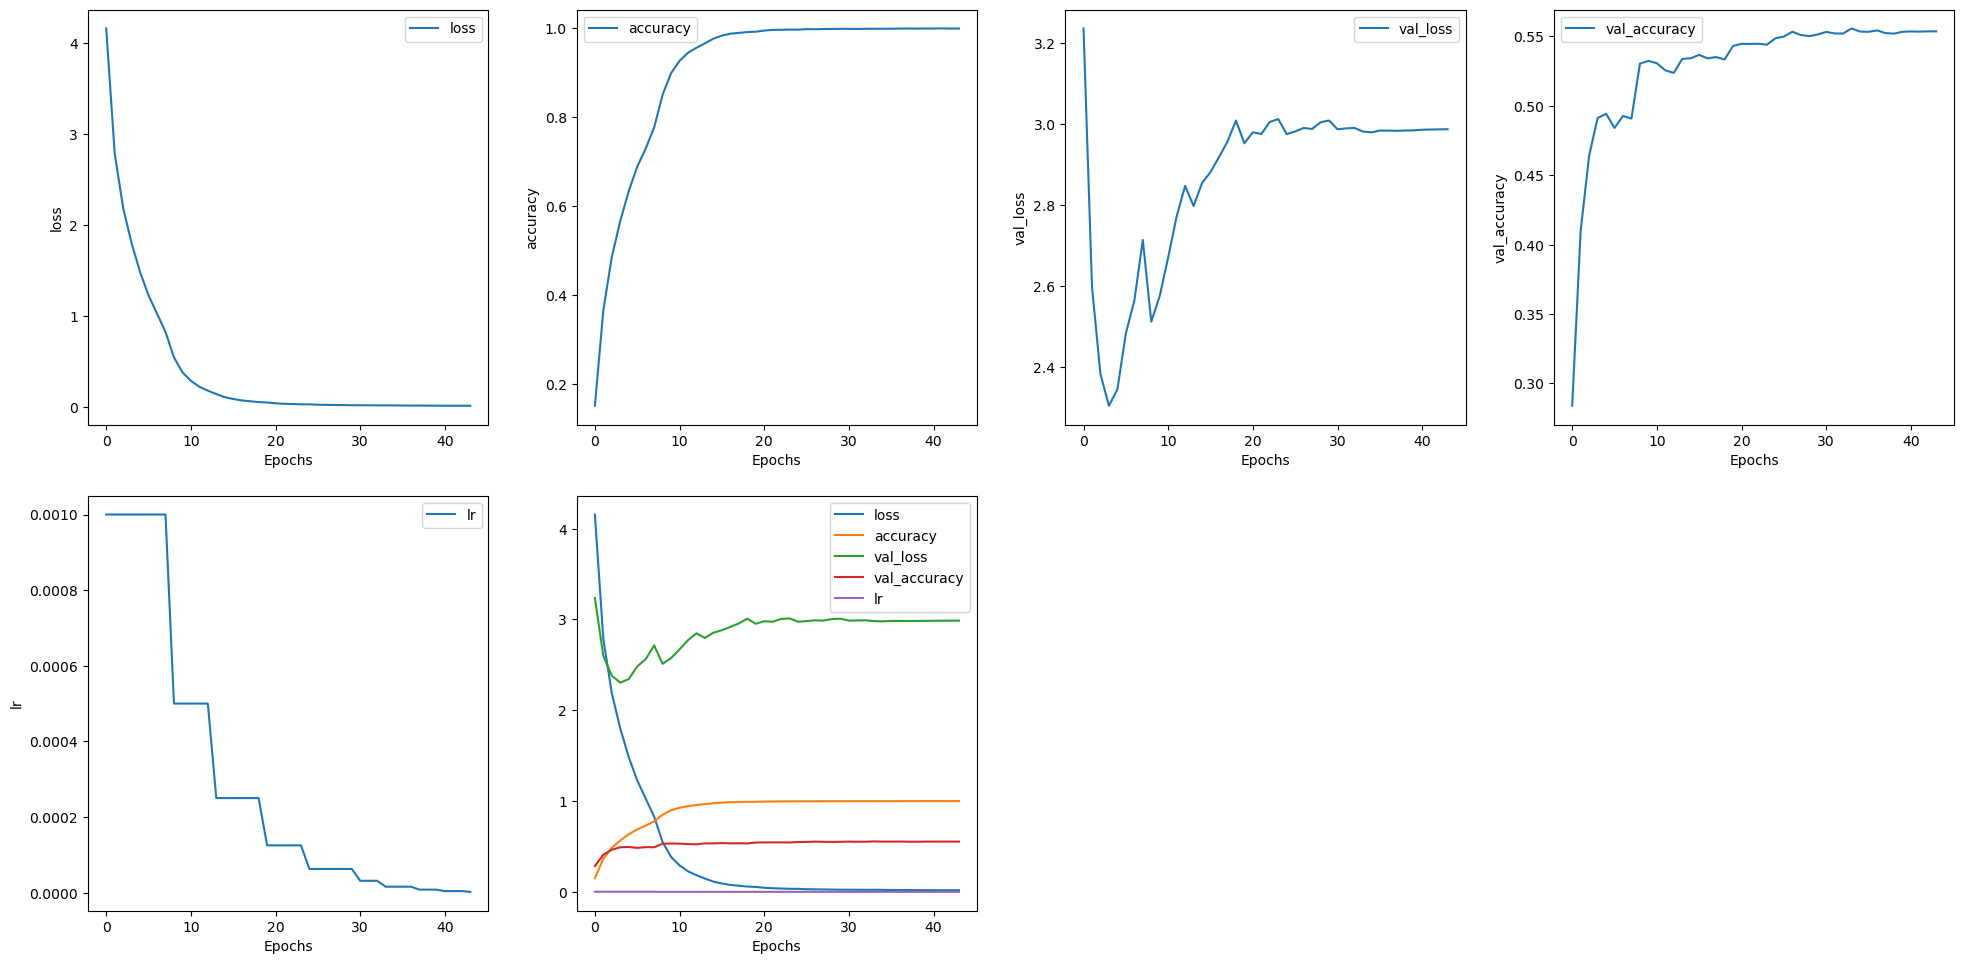

In [22]:
def plot_history(history, zoom=0):
    df = pd.DataFrame(history.history)
    n = len(df.columns)

    row = n // 2
    col = n // 2 + n % 2

    plt.figure(figsize=(5 * (col + 1) + zoom, 5 * row + zoom))
    for i, column in enumerate(df.columns):
        plt.subplot(row, col + 1, i + 1)
        plt.plot(df[f"{column}"], label=f"{column}")
        plt.legend()
        plt.xlabel("Epochs")
        plt.ylabel(f"{column}")
        plt.tight_layout(pad=2)  # padding

    plt.subplot(row, col + 1, n + 1)
    for column in df.columns:
        plt.plot(df[f"{column}"], label=f"{column}")
        plt.legend()
    plt.xlabel("Epochs")

plot_history(history)

## Inference Model

In [23]:
class TFLiteModel(tf.keras.Model):
    def __init__(self, model):
        super().__init__()
        self.prep_inputs = FeaturePreprocess()
        self.model = model
        
    @tf.function(input_signature=[tf.TensorSpec(shape=[None, 543, 3], dtype=tf.float32, name='inputs')])
    def call(self, inputs):
        x = self.prep_inputs(tf.cast(inputs, dtype=tf.float32))
        x = tf.expand_dims(x, axis=0)
        outputs = self.model(x)[0, :]
        
        return {'outputs': outputs}

tflite_keras_model = TFLiteModel(model)

In [24]:
converter = tf.lite.TFLiteConverter.from_keras_model(tflite_keras_model)

converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
converter.inference_input_type = tf.float32
converter.inference_output_type = tf.float32
converter.experimental_new_converter = True
converter.input_shape = (None, 543, 3)  # set the input shape explicitly
tflite_model = converter.convert()

In [25]:
# Save model
model_path = "model.tflite"
with open(model_path, "wb") as f:
    f.write(tflite_model)

In [26]:
!zip submission.zip $model_path

  adding: model.tflite (deflated 26%)


In [27]:
interpreter = tf.lite.Interpreter("/kaggle/working/model.tflite")

found_signatures = list(interpreter.get_signature_list().keys())
prediction_fn = interpreter.get_signature_runner("serving_default")

p2s_map = {v:k for k,v in label_map.items()}
decoder = lambda x: p2s_map.get(x)

score = 0 
for i in tqdm(range(int(len(train_df)/10))): 
    frames = load_landmarks(os.path.join(CONFIG.ROOT_DIR, train_df.iloc[i].path))
    output = prediction_fn(inputs=frames)
    sign = np.argmax(output["outputs"])
    if decoder(train_df.iloc[i].label) == decoder(sign): 
        score += 1 
print(score/int(len(train_df)/10))

INFO: Created TensorFlow Lite delegate for select TF ops.
INFO: TfLiteFlexDelegate delegate: 2 nodes delegated out of 82 nodes with 2 partitions.

100%|██████████| 9447/9447 [07:24<00:00, 21.25it/s]

0.9118238594262729
